# Training conditional Generative Flow Networks

So far, GFNs have been used to learn a parameterized density model $p_\theta(x) \propto R(x)$ for some given $R$.

Can we use this framework to train conditional generative models $p(x|\omega) \propto R(x|\omega)$? In particular, can we use these conditional models to:
- learn to tradeoff between various reward signals, e.g. where $R(x|\omega) = \sum_i \omega_i R_i(x)$ s.t. $\sum_i \omega_i = 1$
- learn to tradeoff between exploratory and greedy behaviors, i.e. learn $R(x|\beta) = R(x)^\beta$ and the corresponding $p$.

Let's look at a few simple scenarios. 

In this notebook, I'm using the [Trajectory Balance](https://arxiv.org/abs/2201.13259) objective, and the corresponding implementation [here](https://github.com/recursionpharma/gflownet/blob/trunk/gflownet/examples/grid_cond_gfn.py).

In the [original GFlowNet paper](https://folinoid.com/w/gflownet/) we learn a flow $F$ such that the in-flows and out-flows of a state $s'$ are balanced:
$$\sum_{(s,a) \to s'} F(s,a) = R(s') + \sum_{a'\in \mathcal{A}(s')} F(s',a')$$
This yields a _forward policy_ $P_F(s \to s') \equiv P_F(a|s)$ which determines the probability of landing in a particular state, and which, at convergence, yields $X \sim F_B \iff p(X) \propto R(X)$. Interestingly, to $P_F$ and $F$ corresponds a _backward_ policy $P_B$, which intuitively, tells you where the flow "came from" in a node.

In Trajectory Balance, it is observed that we have the following, for a sequence of state $(s_t,...,s_T)$:
$$ F(s_t)\prod_{i=t}^{T-1} P_F(s_i \to s_{i+1}) = F(s_T)\prod_{i=t}^{T-1} P_B(s_{i+1} \to s_i)$$
Intuitively, this says that the amount of flow going through a subtrajectory from $s_t$ to $s_T$ must match the reverse flow from $s_T$ to $s_t$. Noting that $F(s_0)=Z$ and $F(s_T)=R(s_T)$ for terminal states, this yields a learning objective over entire trajectories. In TB, we learn $P_F$ (and optionally $P_B$), as well as $Z$.

For a conditional GFN, we are going to learn $Z(\omega; \theta)$ and $P_F(a|s, \omega; \theta)$. In terms of implementation, we simply augment the input of the neural network modeling $P_F$ (and turn $Z$ from a learned single parameter to an MLP as well).


[Setup code]

In [1]:
import grid_cond_gfn as gfn
import itertools
import torch
import matplotlib.pyplot as pp
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib as mpl
import pickle
import gzip
import numpy as np
import os
import scipy.stats as stats
from itertools import product
from collections import defaultdict 

from matplotlib.pyplot import figure



 # Some plotting routines
def binavg(x, n=100, var=False, 
            bounds=False, logx=False):
    if len(x) < n:
        return np.linspace(0, len(x), len(x)), x, 0*x+1, 0 * x, np.stack([x, x]).T
    if logx:
        bins = np.logspace(0, np.log(len(x))/np.log(10), n)
        idx = np.digitize(np.arange(len(x)), bins)
    else:
        bins = np.linspace(0, len(x), n)
        idx = np.int32(np.linspace(0, n, len(x)+1))[:-1]
    counts = np.bincount(idx, minlength=n)
    _y = y = np.bincount(idx, x, minlength=n) / counts
    bins = bins[counts>0]
    y = y[counts>0]
    r = (bins, y, counts)
    if var:
        var = np.sqrt(np.bincount(idx, x**2, minlength=n) / np.bincount(idx, minlength=n) - _y**2)
        r += (var[counts>0], )
    if bounds:
        r += (np.float32([(x[idx==i].min(),x[idx==i].max()) for i in range(n) if counts[i] > 0]), ) 
    return r
 
def smooth_plot(x, n=100, fill_var=False, fill_minmax=False, logx=False, **kw):
    bins, y, counts, var, bounds = binavg(x, n, var=True, bounds=True, logx=logx)
    if 'bins' in kw:
        bins = kw.pop('bins')[counts>0]
    l, = pp.plot(bins, y, **kw)
    if fill_var:
        pp.fill_between(bins, y-var, y+var, alpha=0.25, color=l.get_c())
    elif fill_minmax:
        pp.fill_between(bins, bounds[:, 0], bounds[:, 1], alpha=0.25, color=l.get_c())
    return l


top = cm.get_cmap('Blues_r', 128)
bottom = cm.get_cmap('Oranges', 128)

newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')

mpl.rc('image', cmap=newcmp)

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# More reward dimensions
def sphere(x):
    d = 2
    current_sum = 0;
    y_max = 2.0
    for i in range(d):
        current_sum = current_sum + (x[..., i] ** 2)
    y = current_sum
    y /= y_max
    return y

def beale(x):
    y_min = 4.369943360497595
    y_max = 38.703125
    term1 = np.square(1.5 - x[..., 0] + x[..., 0] * x[..., 1])
    term2 = np.square(2.25 - x[..., 0] + x[..., 0]* np.square(x[..., 1]))
    term3 = np.square(2.625 - x[..., 0] + x[..., 0] * np.power(x[..., 1], 3));
    y = term1 + term2 + term3
    return (y - y_min) / (y_max - y_min)

def perm(x):
    y = (11*(x[:, 1]-1) + 12 * (x[:, 1]-0.5))**2 + (11*(x[:, 0]**2-1)+12*(x[:, 1]**2-0.25))**2
    return (y - y.min()) / (y.max() - y.min())

def bukin(x):
    ab=np.fabs(x[:, 1]-0.01 * x[:, 0] * x[:, 0])
    y = 100*np.sqrt(ab)+0.01*np.fabs(x[:, 0]+10)
    return (y - y.min()) / (y.max() - y.min())

def shubert(x):
    sum1=0
    sum2=0
    y_min = -12.58133095975989
    y_max = 12.85231572911876
    for i in range(1,6):
        sum1 = sum1 + (i* np.cos(((i+1)*x[..., 0]) + i * 10))
        sum2 = sum2 + (i* np.cos(((i+1)*x[..., 1]) + i * 10))
    y = sum1 * sum2
    return (y - y_min) / (y_max - y_min)


def matyas(x):
    term1 = 0.26 * (np.square(x[:, 0]) + np.square(x[:, 1]))
    term2=  x[:, 0] * x[:, 1]
    
    y = term1 - term2
    return (y - y.min()) / (y.max() - y.min())

## Reward visualization

Now we look at $d$ classic optimization function defined on $[0, 1]^d$. The aim is to train a gflownet which learns a preference vector $\omega \in \mathbb{R}^d$ on this $d$ dimensional rewards

4.369943360497595 38.703125


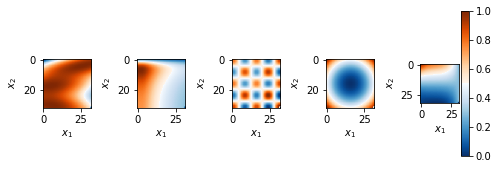

In [13]:
def visualize_reward():
    H = 32
    functions = [gfn.branin, gfn.currin, shubert, sphere, beale
                ]
    env = gfn.GridEnv(H, funcs=functions)
    s, r, pos = env.state_info()
    f, ax = pp.subplots(1,len(functions), figsize=(7,3))
    for i in range(len(functions)):
        pp.sca(ax[i])
        reward = r[:, i]
        pp.imshow(np.concatenate([reward, [0]]).reshape((H,H)))
        pp.xlabel('$x_1$')
        pp.ylabel('$x_2$')
    pp.colorbar()
    pp.tight_layout()
    pp.savefig("rewards.png")
    return r
r = visualize_reward()

Here is what some convex tradeoffs between these two functions look like:

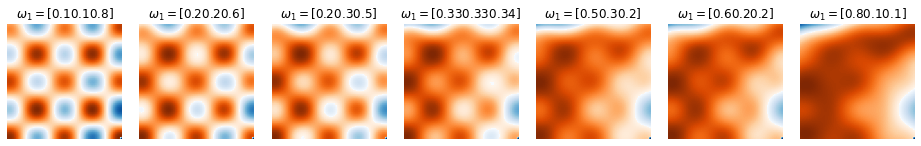

In [4]:
def reward_dist_with_preferences():
    H = 64
    env = gfn.GridEnv(64, funcs=[gfn.branin, gfn.currin, shubert])
    s, r, pos = env.state_info()

    preferences = np.array([[0.1, 0.1, 0.8],
                           [0.2, 0.2, 0.6],
                           [0.2, 0.3, 0.5],
                           [0.33, 0.33, 0.34],
                           [0.5, 0.3, 0.2],
                           [0.6, 0.2, 0.2],
                           [0.8, 0.1, 0.1]])   
    f, ax = pp.subplots(1,preferences.shape[0], figsize=(13,2))
    for i in range(preferences.shape[0]):
        pp.sca(ax[i])
        y = r[:, 0] * preferences[i, 0] + r[:, 1] * preferences[i, 1] + r[:, 2] * preferences[i, 2]
        pp.imshow(np.concatenate([y, [0]]).reshape((H,H)))
        pp.axis('off')
        pp.title(f'$\omega_1={preferences[i]}$')
    pp.tight_layout()
    pp.savefig("conditional_rewards.png")
reward_dist_with_preferences()

To make this more interesting let's see how the maxima change if we set the inverse temperature to $\beta = 8$:

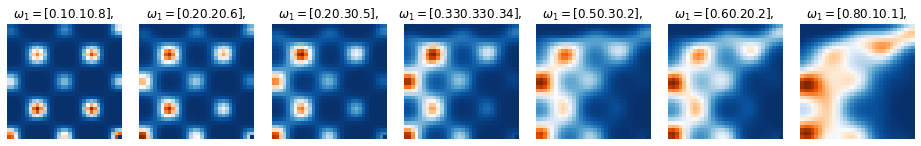

In [5]:
def reward_dist_with_temp(temperature=8):
    H = 32
    env = gfn.GridEnv(H, funcs=[gfn.branin, gfn.currin, shubert])
    s, r, pos = env.state_info()
    preferences = np.array([[0.1, 0.1, 0.8],
                           [0.2, 0.2, 0.6],
                           [0.2, 0.3, 0.5],
                           [0.33, 0.33, 0.34],
                           [0.5, 0.3, 0.2],
                           [0.6, 0.2, 0.2],
                           [0.8, 0.1, 0.1]])   
    f, ax = pp.subplots(1,preferences.shape[0], figsize=(13,2))
    for i in range(preferences.shape[0]):
        pp.sca(ax[i])
        y = (r[:, 0] * preferences[i, 0] + r[:, 1] * preferences[i, 1] + r[:, 2] * preferences[i, 2]) ** temperature

        pp.imshow(np.concatenate([y, [0]]).reshape((H,H)))
        pp.axis('off')
        pp.title(f'$\omega_1={preferences[i]}$, ')
    pp.tight_layout()
reward_dist_with_temp()

We can see some fun multimodality happening with the Branin function.

What does the Pareto front of this function look like? Here we scatter the rewards of the discretization (one dot per grid position), red squares are Pareto optimal points.

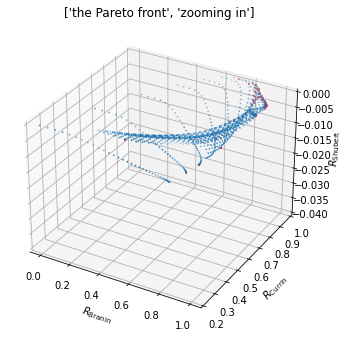

In [6]:
def get_pareto():
    H = 32
    env = gfn.GridEnv(H, funcs=[gfn.branin, gfn.currin, shubert])
    s, r, pos = env.state_info()
    # f, ax = pp.subplots(1,2, figsize=(9,4), projection='3d')
    # f = pp.figure(figsize=(12, 12))
    fig = pp.figure(figsize=(12, 12))
    # for axi in range(2):
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    pp.sca(ax1)
    pp.scatter(r[:, 0], r[:, 1], r[:, 2])
    pareto = []
    re = r.T
    for i in range(re.shape[1]):
        d = ((re[:, i, None] - re) < 0).prod(0).sum()
        if d == 0:
            pareto.append(re[:, i])
    pareto = np.float32(pareto)
    pp.scatter(pareto[:, 0], pareto[:, 1], pareto[:, 2], marker='s', color='red')
    # pp.xlim([(0.2,1.02), (0.7,1.02)])
    # pp.ylim([(0.1,1.02), (0.4,1.02)])
    # ax1.set_xlim(0., 1)
    ax1.set_ylim(0.2, 1)
    ax1.set_zlim(-0.04, 0.0)
    pp.title(['the Pareto front', 'zooming in'])
    ax1.set_xlabel('$R_{\mathrm{Branin}}$')
    ax1.set_ylabel('$R_{\mathrm{Currin}}$')
    ax1.set_zlabel('$R_{\mathrm{Shubert}}$')
    pp.savefig("Pareto_frontier.png")
get_pareto()


Let's now look at how a GFN performs on this. To train the GFN, we must notably train it to predict different flows as a function of the conditioning information, here $\omega$ and $\beta$. For $\omega$, we use samples from a Dirichlet(1.5, 1.5), and for $\beta$, samples from a Gamma(2,1) distribution for each new sampled trajectory.

[0, 1, 2, 3, 4, 5, 6, 7, 8]


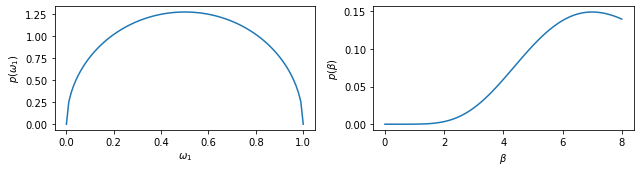

In [16]:
import scipy.stats as stats
f, ax = pp.subplots(1,2,figsize=(9,2.5))
pp.sca(ax[0])
pp.plot(np.linspace(0,1,100), stats.dirichlet.pdf([np.linspace(0,1,100),1-np.linspace(0,1,100)], [1.5,1.5]))
pp.ylabel('$p(\\omega_1)$')
pp.xlabel('$\\omega_1$')
pp.sca(ax[1])
pp.plot(np.linspace(0,8,100), stats.gamma.pdf(np.linspace(0,8,100), 8, scale=1))
pp.ylabel('$p(\\beta)$')
pp.xlabel('$\\beta$')
pp.tight_layout()
print(list(range(9)))

We also discretize $[0,1]^2$ into a 16x16 grid in order to apply GFlowNet. We use a small MLP to train $P_F(.|\omega)$ and $Z(\omega)$, and we use a uniform $P_B$.

Now let's look at the convex tradeoff plots again. Here the top row is what is learned and the bottom row the ground truth:

Again with $\beta = 4$:

In [ ]:
def plot_beta_evolution(horizon):
    results = pickle.load(gzip.open(os.getcwd() + '/resultsv2/reverse_annealing_horizon_{}_.pkl.gzbeta_1.pkl.gz'.format(horizon), 'rb'))
    H = results['args'].horizon
    env = gfn.GridEnv(H, funcs=[gfn.branin, gfn.currin, shubert])
    s, r, pos = env.state_info()
    row = 0
    betas_idxs = range(5)
    betas = [1, 2, 4, 8, 16]
    
    for beta in betas_idxs:
        f, ax = pp.subplots(2,7,figsize=(18,4), sharex=True, sharey=True)
        coefs = [] # This is a bad bad bad way of coding
        for col in range(7):
            coef, temp = results['cond_confs'][col * 5 + beta]
            coefs.append(coef)
            pp.sca(ax[0, col])
            if col == 3:
                pp.title("Learned Distribution | Horizon : {} | Beta {} ".format(H, betas[beta]))
            pp.imshow(np.concatenate([results['final_distribution'][:, col * 5 + beta], [0]]).reshape((H,H)))
            pp.sca(ax[1, col])
            if col == 3:
                pp.title("Ground Truth Distribution")
            pp.imshow(np.concatenate([(r[:, 0] * coef[0] + r[:, 1] * coef[1]+ r[:, 2] * coef[2])**temp, [0]]).reshape((H,H)))
        pp.savefig(os.getcwd() + '/plots/tab_beta_evol_horizon_{}_beta_{}_coefs_{}_v2.png'.format(horizon, betas[beta], coef))
    return coefs


For different horizons $H = [16, 32, 64]$

In [ ]:
def plot_horizon_evolution(beta):
    horizons = [16, 32, 64]
    betas = [1, 2, 4, 8, 16] # home/gflownet/gflownet/examples/resultsv2/annealing_horizon_16_.pkl.gzbeta_1.pkl.gz
    for hor in horizons:
        results = pickle.load(gzip.open(os.getcwd() + '/results/annealing_horizon_{}_.pkl.gzbeta_1.pkl.gz'.format(hor), 'rb'))
        env = gfn.GridEnv(hor, funcs=[gfn.branin, gfn.currin, shubert])
        s, r, pos = env.state_info()
        row = 0
        f, ax = pp.subplots(2,7,figsize=(18,4), sharex=True, sharey=True)
        for col in range(7):
            coef, temp = results['cond_confs'][col * 5 + beta]
            pp.sca(ax[0, col])
            if col == 3:
                pp.title("Learned Distribution | Horizon {} | Beta {} ".format(hor, betas[beta]))
            pp.imshow(np.concatenate([results['final_distribution'][:, col * 5 + beta], [0]]).reshape((hor,hor)))
            pp.sca(ax[1, col])
            if col == 3:
                pp.title("Ground Truth Distribution")
            pp.imshow(np.concatenate([(r[:, 0] * coef[0] + r[:, 1] * coef[1]+ r[:, 2] * coef[2])**temp, [0]]).reshape((hor,hor)))
        pp.savefig(os.getcwd() + '/plots/horizon_evol_horizon_{}_beta_{}_coefs_{}_v2.png'.format(hor, beta, coef))


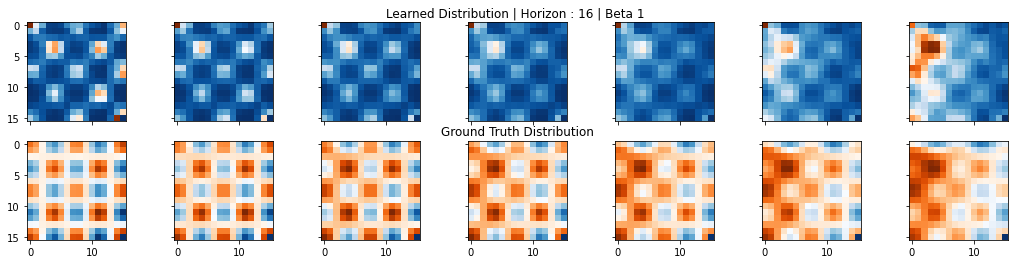

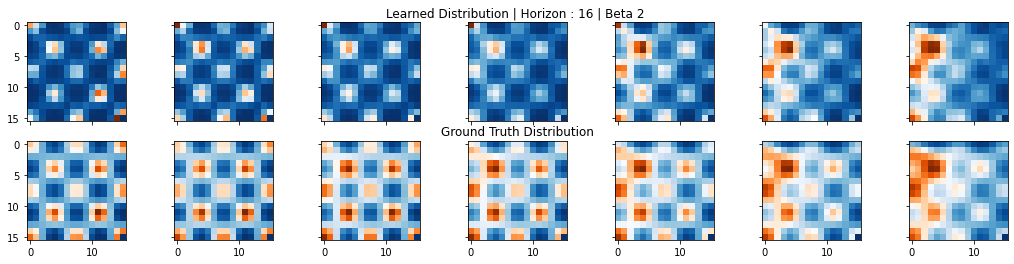

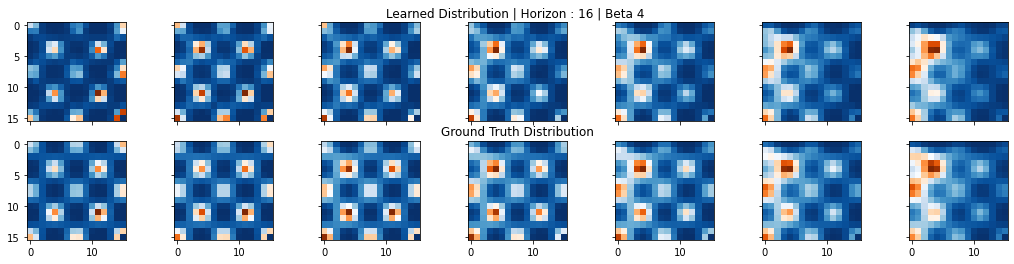

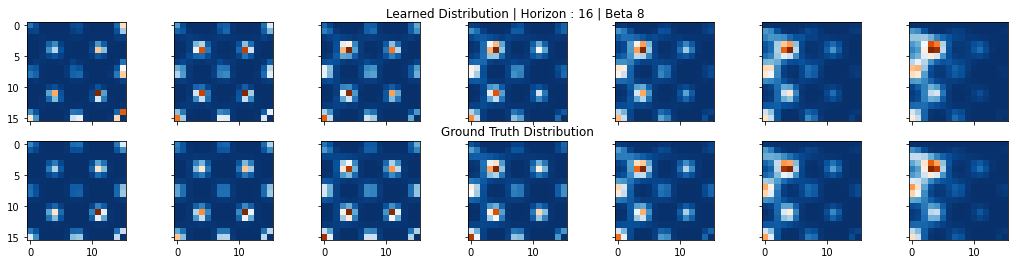

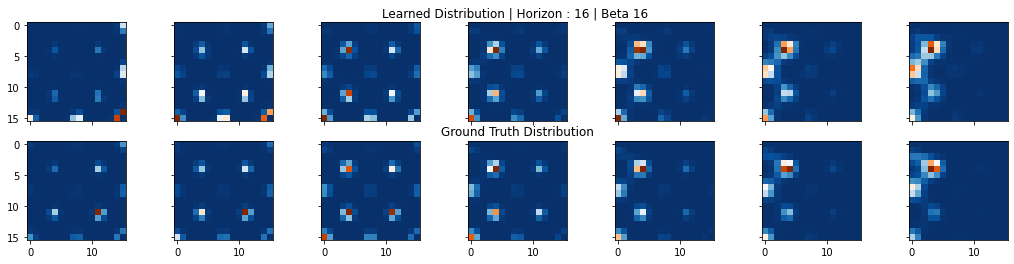

In [ ]:
coefs = plot_beta_evolution(horizon=32)

In [49]:
plot_horizon_evolution(beta=3)

FileNotFoundError: [Errno 2] No such file or directory: '/run/determined/workdir/home/gflownet/gflownet/examples/results/example_3d_reward_16_horizon_alpha_2_beta_1.pkl.gz'

In [96]:
from PIL import Image
def gif_horizon_evolution(coeficients, beta=1):
    
    horizons = [16, 32, 64]
    coef = coeficients[-1]
    fp_out = os.getcwd() + '/gifs/horizon_evolution_beta_{}.gif'.format(beta)
    file_names = [os.getcwd() + '/plots/horizon_evol_horizon_{}_beta_{}_coefs_{}.png'.format(hor, beta, coef) for hor in horizons]
    imgs = (Image.open(f) for f in file_names)
    img = next(imgs)  # extract first image from iterator
    img.save(fp=fp_out, format='GIF', append_images=imgs,
             save_all=True, duration=1000, loop=0)

def gif_beta_evolution(coeficients, horizon=32):
    val = 16
    betas = [1, 2, 4, 8, 16]
    coef = coeficients[-1]
    fp_out = os.getcwd() + '/gifs/const_beta_{}_evolution_horizon_{}.gif'.format(val, horizon)
    file_names = [os.getcwd() + '/plots/tab_beta_{}_evol_horizon_{}_beta_{}.png'.format(val, horizon, beta) for beta in betas]
    imgs = (Image.open(f) for f in file_names)
    img = next(imgs)  # extract first image from iterator
    img.save(fp=fp_out, format='GIF', append_images=imgs,
             save_all=True, duration=1500, loop=0)

Another fun thing we can look at is how well the model is doing as a function of $\omega$ and $\beta$. Here on the left we show the MAE $\mathbb{E}_x|p(x|\beta,\omega)-p_\theta(x|\beta,\omega)|$ and on the right we show the mean absolute log-error $\mathbb{E}_x|\log p(x|\beta,\omega)-\log p_\theta(x|\beta,\omega)|$:

In [97]:
# gif_horizon_evolution(coefs, beta=1)
gif_beta_evolution(coefs, horizon=32)

ValueError: The number of FixedLocator locations (28), usually from a call to set_ticks, does not match the number of ticklabels (32).

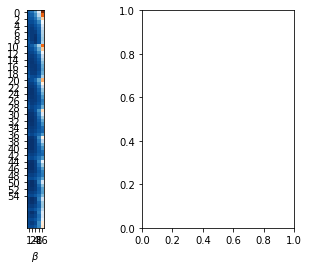

In [17]:
# Repeat this for alpha and beta and for all coefficients 
results = pickle.load(gzip.open(os.getcwd() + '/results/example_3d_reward_{}_horizon_alpha_2_beta_2.pkl.gz'.format(32), 'rb'))
data = results
errs = []
logerrs = []
for (coef, t), dist in zip(data['cond_confs'], data['final_distribution'].T):
    unnorm_p = (r[:, 0]*coef[0]+r[:,1]*coef[1]+ r[:, 2] * coef[2])**t
    Z = unnorm_p.sum()
    p = unnorm_p / Z
    errs.append(abs(dist - p).mean())
    logp = np.log(unnorm_p) - np.log(Z)
    logerrs.append(abs(np.log(dist) - logp).mean())
f, ax = pp.subplots(1,2)
pp.sca(ax[0])
pp.imshow(np.float32(errs).reshape((64,5)))
pp.xticks(range(5), [1,2,4,8,16])
pp.xlabel('$\\beta$')
pp.yticks(range(0,55,2), np.arange(0,64,2)/10)
pp.ylabel('$\\omega_1$')
pp.colorbar(label='abs prob error')
pp.sca(ax[1])
pp.imshow(np.float32(logerrs).reshape((64,5)))
pp.xticks(range(5), [1,2,4,8,16])
pp.xlabel('$\\beta$')
pp.yticks(range(0,55,2), np.arange(0,64,2)/10)
pp.ylabel('$\\omega_1$')
pp.colorbar(label='abs log prob error')
pp.tight_layout()
pp.subplots_adjust(wspace=0.75)

As noted earlier, since we sample $\omega$ from a Dirichlet that peaks at 0.5, we get (as expected) that the error is a bit higher at the edges (for $\omega_1=0$ and $=1$). Also remember that $\beta$ is sampled from Gamma(2,1), this means the model sees $\beta\geq 8$ only

In [37]:

print(f'{100 - 100 * stats.gamma.cdf(8, 2, scale=1): .2f}%')

NameError: name 'stats' is not defined

of the time! It sees $\beta=16$ even less. Interestingly at this point, it forgets some modes, but remembers the "gist" of it.

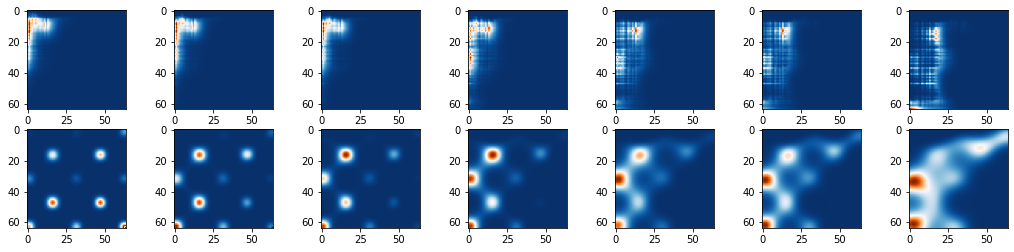

In [142]:
f, ax = pp.subplots(2,7,figsize=(18,4))
H = results['args'].horizon
env = gfn.GridEnv(H, funcs=[gfn.branin, gfn.currin, shubert])
s, r, pos = env.state_info()
row = 0
for col in range(7):
    coef, temp = results['cond_confs'][col * 5 + 4]
    pp.sca(ax[0, col])
    pp.imshow(np.concatenate([results['final_distribution'][:, col * 5 + 4], [0]]).reshape((H,H)))
    pp.sca(ax[1, col])
    pp.imshow(np.concatenate([(r[:, 0] * coef[0] + r[:, 1] * coef[1]+ r[:, 2] * coef[2])**temp, [0]]).reshape((H,H)))

Let's now look at the $Z$ predictions the GFN model is making.

The left plot shows again the error (but this time on $Z$) as a function of $\omega$ and $\beta$. The middle left plot shows the same error but with a different coloring. The two right plots the the predicted and true $\log Z$ values. It's interesting to note here that error is less consistent than with $p(x)$, and also that it may be due to the prediction being "too smooth" as a function of $\omega$.

In [143]:
agent = gfn.FlowNet_TBAgent(data['args'], [env])
for a,b in zip(agent.parameters(), data['params']):
    a.data = torch.tensor(b)
preds = []
for coef, t in data['cond_confs']:
    env.reset(coef, t)
    preds.append((agent.Z(torch.tensor(env.cond_obs).float()).item(), np.log(((r[:, 0]*coef[0]+r[:,1]*coef[1]+r[:,2]*coef[2])**t).sum())))

NameError: name 'env' is not defined

In [142]:
preds = np.float32(preds)
f, ax = pp.subplots(1,4,figsize=(12,4))
pp.sca(ax[0])
err = abs(preds[:, 0] - preds[:,1])
pp.imshow(err.reshape((7,5)))
pp.xticks(range(5), [1,2,4,8,16])
pp.xlabel('$\\beta$')
pp.yticks(range(0,7,2), np.arange(0,7,2)/10)
pp.ylabel('$\\omega_1$')
pp.colorbar()
pp.title('abs log Z err')

pp.sca(ax[1])
err = np.log(abs(preds[:, 0] - preds[:,1])) / np.log(10)
pp.imshow(err.reshape((7,5)))
pp.xticks(range(5), [1,2,4,8,16])
pp.xlabel('$\\beta$')
pp.yticks(range(0,7,2), np.arange(0,7,2)/10)
#pp.ylabel('$\\omega_1$')
pp.title('abs log Z err (log-colored)')
cb = pp.colorbar(ticks=np.linspace(-2.5,0.5,7))
cb.ax.set_yticklabels([f'${m}\\times 10^{{{int(e)}}}$' for i in np.linspace(-2.5,0.5,7) for m,e in [f'{10**i:.0E}'.split('E')]])

pp.sca(ax[2])
err = np.log(preds[:, 0])
pp.imshow(err.reshape((7,5)))
pp.xticks(range(5), [1,2,4,8,16])
pp.xlabel('$\\beta$')
pp.yticks(range(0,7,2), np.arange(0,7,2)/10)
pp.title('predicted log Z')
pp.colorbar()

pp.sca(ax[3])
err = np.log(preds[:, 1])
pp.imshow(err.reshape((7,5)))
pp.xticks(range(5), [1,2,4,8,16])
pp.xlabel('$\\beta$')
pp.yticks(range(0,7,2), np.arange(0,7,2)/10)
pp.title('True log Z')
pp.colorbar()
pp.tight_layout()

NameError: name 'preds' is not defined

Let's finally plot the training loss of the model:

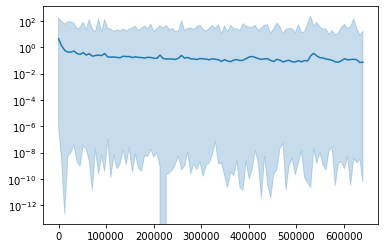

In [138]:
l = smooth_plot(np.float32(data['losses'])[:,0], 100, fill_minmax=True)
pp.yscale('log')
pp.savefig("training_loss.png")

It seems high variance, but at least going down consistently. In particular I'm also filling the min/max values of the loss, and there does seem to be the occasional very high loss.

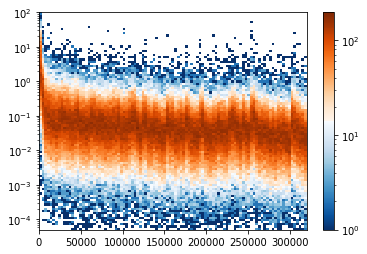

In [152]:
import matplotlib.colors as colors
x, y = np.arange(len(data['losses'])), np.float32(data['losses'])[:,0]
pp.hist2d(x,y, [np.linspace(0, len(x), 100), np.logspace(-4.3, 2, 100)], norm=colors.LogNorm())
pp.yscale('log')
pp.colorbar()
pp.savefig("loss_hist.png")

### Running experiments

In this notebook I've directly loaded pickled results from a previous run. You can run the provided code, or try it out from directly from this notebook (lots of CPUs recommended). For example:

In [18]:
import grid_cond_gfn as gfn
hps = gfn.parser.parse_args([])
hps.save_path = None 
hps.progress = True
hps.horizon = 16
hps.n_train_steps = 1000 # The more steps the better
hps.opt = 'adam'
hps.mbsize = 128
hps.learning_rate = 1e-2
hps.n_hid = 64
hps.n_layers = 3

# To make this experiment run faster, batching can be parallelised over multiple cpus:
hps.n_procs = 32

results = gfn.main(hps)

0.01622 4.82535: 100%|██████████| 1001/1001 [02:48<00:00,  5.95it/s]


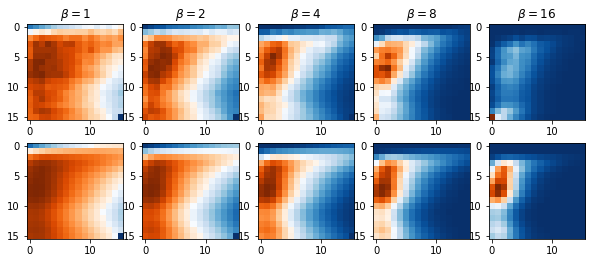

In [19]:
f, ax = pp.subplots(2,5,figsize=(5*2,4))
H = results['args'].horizon
env = gfn.GridEnv(H, funcs=[gfn.branin, gfn.currin])
s, r, pos = env.state_info()
row = 0
for col in range(5):
    coef, temp = results['cond_confs'][5 * 5 + col]
    pp.sca(ax[0, col])
    pp.imshow(np.concatenate([results['final_distribution'][:, 5 * 5 + col], [0]]).reshape((H,H)))
    pp.title(f"$\\beta={temp}$")
    pp.sca(ax[1, col])
    pp.imshow(np.concatenate([(r[:, 0] * coef[0] + r[:, 1] * coef[1])**temp, [0]]).reshape((H,H)))

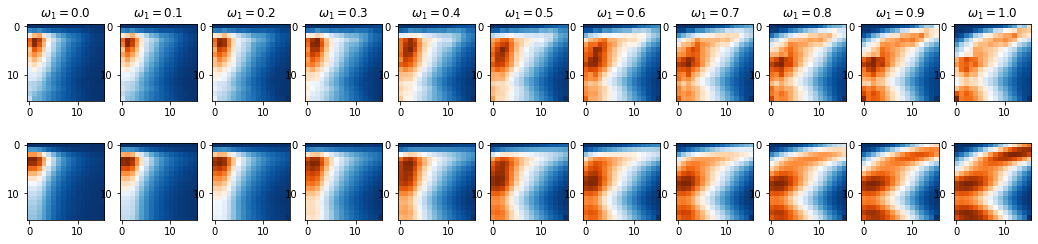

In [20]:
f, ax = pp.subplots(2,11,figsize=(18,4))
H = results['args'].horizon
env = gfn.GridEnv(H, funcs=[gfn.branin, gfn.currin])
s, r, pos = env.state_info()
row = 0
for col in range(11):
    coef, temp = results['cond_confs'][col * 5 + 2]
    pp.sca(ax[0, col])
    pp.imshow(np.concatenate([results['final_distribution'][:, col * 5 + 2], [0]]).reshape((H,H)))
    pp.title(f"$\\omega_1={coef[0]:.1f}$")
    pp.sca(ax[1, col])
    pp.imshow(np.concatenate([(r[:, 0] * coef[0] + r[:, 1] * coef[1])**temp, [0]]).reshape((H,H)))

Loss:

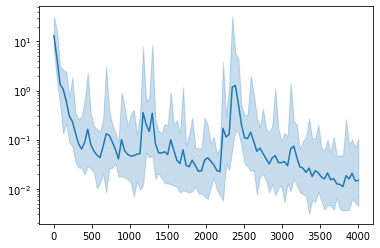

In [21]:
smooth_plot(np.float32(results['losses'])[:,0], 100, fill_minmax=True)
pp.yscale('log')

In [22]:
H = results['args'].horizon
env = gfn.GridEnv(H, funcs=[gfn.branin, gfn.currin])
model = gfn.FlowNet_TBAgent(results['args'], [env])
for a, b in zip(model.parameters(), results['params']):
    a.data = torch.tensor(b)
s, r, pos = env.state_info()


Learned logits (down, right, stop):

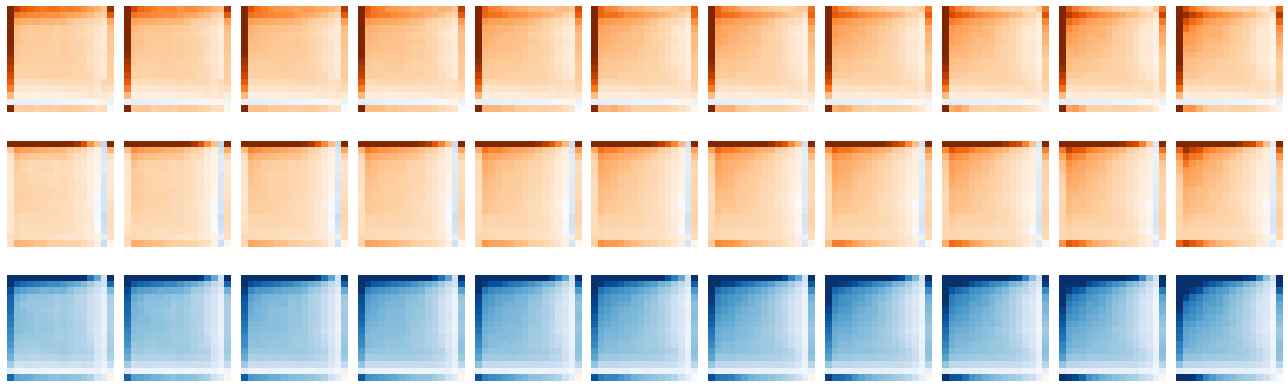

In [23]:
f, ax = pp.subplots(3,11,figsize=(18,6))
for col in range(11):
    #coef, temp = results['cond_confs'][col * 5]
    coef = col / 10
    env.cond_obs = np.float32([coef, 1-coef, 2])
    with torch.no_grad():
        pred = model.model(torch.tensor([env.obs(p) for p in pos]).float())
    for j in range(3):
        pp.sca(ax[j, col])
        pp.imshow(np.concatenate([pred[:, j].numpy(), [0]]).reshape((H,H)), vmin=-2, vmax=2)
        pp.axis('off')
pp.tight_layout()

Learned policy (down, right, stop):

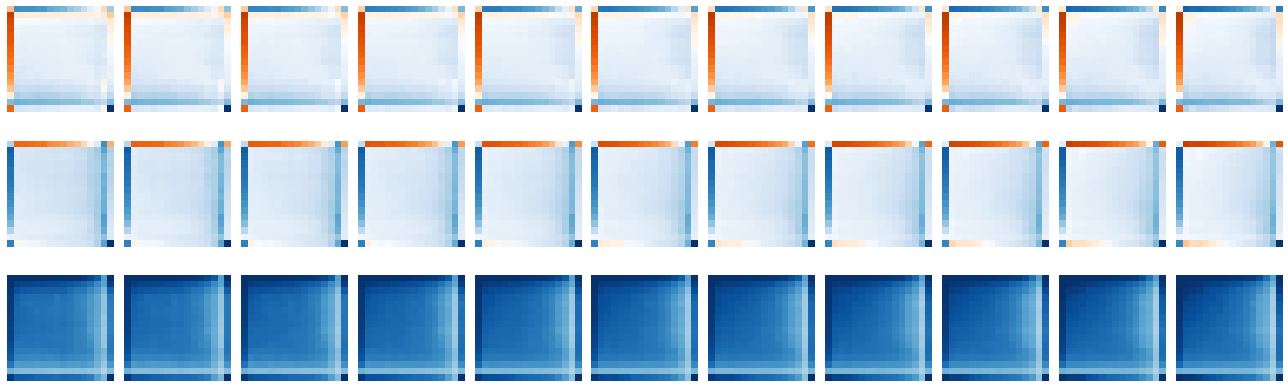

In [24]:
f, ax = pp.subplots(3,11,figsize=(18,6))
sm = torch.nn.Softmax(1)
for col in range(11):
    #coef, temp = results['cond_confs'][col * 5]
    coef = col / 10
    env.cond_obs = np.float32([coef, 1-coef, 2])
    with torch.no_grad():
        pred = sm(model.model(torch.tensor([env.obs(p) for p in pos]).float()))
    for j in range(3):
        pp.sca(ax[j, col])
        pp.imshow(np.concatenate([pred[:, j].numpy(), [0]]).reshape((H,H)), vmin=0, vmax=1)
        pp.axis('off')
pp.tight_layout()

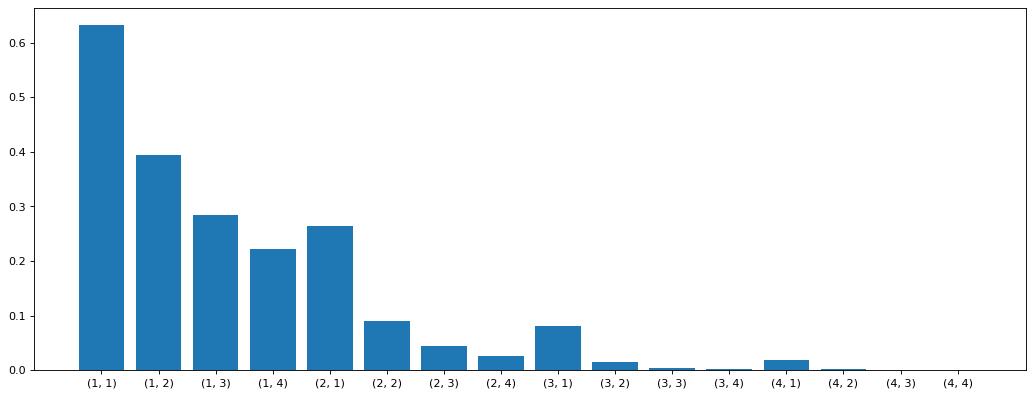

In [26]:
figure(figsize=(16, 6), dpi=80)

combinations = list(product(range(1, 5),repeat = 2))
probs = defaultdict(list)

for comb in combinations:
    betas = stats.gamma.cdf(1, comb[0], scale=comb[1])
    probs[comb] = betas
x = [str(k) for k in probs.keys()]
pp.bar(x, height=list(probs.values()))    
pp.savefig("prob_plot_1.png")

<Figure size 1280x480 with 0 Axes>

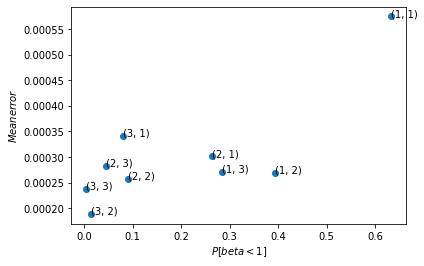

In [13]:
# Repeat this for alpha and beta and for all coefficients 
combinations = [(1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3), (3, 1), (3, 2), (3, 3)]
x_data = []
y_data = []
for idx, comb in enumerate(combinations):
    results = pickle.load(gzip.open(os.getcwd() + '/results/example_3d_reward_{}_horizon_alpha_{}_beta_{}.pkl.gz'.format(32, comb[0], comb[1]), 'rb'))
    data = results
    errs = []
    logerrs = []
    for (coef, t), dist in zip(data['cond_confs'], data['final_distribution'].T):
        
        unnorm_p = (r[:, 0]*coef[0]+r[:,1]*coef[1]+ r[:, 2] * coef[2])**t
        Z = unnorm_p.sum()
        p = unnorm_p / Z
        errs.append(abs(dist - p).mean())
        # logp = np.log(unnorm_p) - np.log(Z)
        # logerrs.append(abs(np.log(dist) - logp).mean())
    x_data.append(probs[comb])
    y_data.append(sum(errs) / len(errs))

x_data = np.asarray(x_data)
y_data = np.asarray(y_data)
figure(figsize=(16, 6), dpi=80)
f, ax = pp.subplots(1,1)
pp.sca(ax)
pp.scatter(x=x_data, y=y_data)

for i, txt in enumerate(combinations):
    ax.annotate(txt, (x_data[i], y_data[i]))
pp.xlabel('$P[beta < 1]$')
pp.ylabel('$Mean error$')
pp.savefig("prob_plot.png")

# # pp.colorbar(label='abs prob error')


Lets plot the loss wrt number of layers 

<Figure size 1280x480 with 0 Axes>

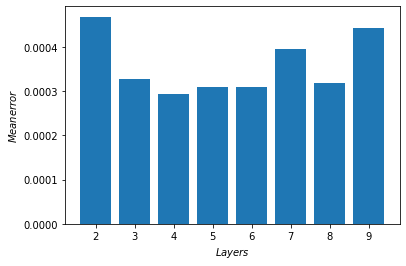

In [50]:
x_data = []
y_data = []
layers = range(2, 10)
for idx, l in enumerate(layers):
    results = pickle.load(gzip.open(os.getcwd() + '/results/example_3d_reward_{}_horizon_alpha_{}_beta_{}_layers_{}.pkl.gz'.format(32, 2, 1, l), 'rb'))
    data = results
    errs = []
    logerrs = []
    for (coef, t), dist in zip(data['cond_confs'], data['final_distribution'].T):
        
        unnorm_p = (r[:, 0]*coef[0]+r[:,1]*coef[1]+ r[:, 2] * coef[2])**t
        Z = unnorm_p.sum()
        p = unnorm_p / Z
        errs.append(abs(dist - p).mean())
        # logp = np.log(unnorm_p) - np.log(Z)
        # logerrs.append(abs(np.log(dist) - logp).mean())
    y_data.append(sum(errs) / len(errs))

x_data = np.asarray(layers)
y_data = np.asarray(y_data)
figure(figsize=(16, 6), dpi=80)
f, ax = pp.subplots(1,1)
pp.sca(ax)
pp.bar(x=x_data, height=y_data)

pp.xlabel('$Layers$')
pp.ylabel('$Mean error$')
pp.savefig("capacity_plot.png")

# # pp.colorbar(label='abs prob error')


In [84]:
def plot_const_beta_evolution(horizon):
    val = 16
    results = pickle.load(gzip.open(os.getcwd() + '/results/const_beta_3d_reward_{}_horizonbeta_{}.pkl.gz'.format(horizon, val), 'rb'))
    H = results['args'].horizon
    env = gfn.GridEnv(H, funcs=[gfn.branin, gfn.currin, shubert])
    s, r, pos = env.state_info()
    row = 0
    betas_idxs = range(5)
    betas = [1, 2, 4, 8, 16]
    
    for beta in betas_idxs:
        f, ax = pp.subplots(2,7,figsize=(18,4), sharex=True, sharey=True)
        coefs = [] # This is a bad bad bad way of coding
        for col in range(7):
            coef, temp = results['cond_confs'][col * 5 + beta]
            coefs.append(coef)
            pp.sca(ax[0, col])
            if col == 3:
                pp.title("Learned Distribution | Horizon : {} | Beta {} ".format(H, betas[beta]))
            pp.imshow(np.concatenate([results['final_distribution'][:, col * 5 + beta], [0]]).reshape((H,H)))
            pp.sca(ax[1, col])
            if col == 3:
                pp.title("Ground Truth Distribution")
            pp.imshow(np.concatenate([(r[:, 0] * coef[0] + r[:, 1] * coef[1]+ r[:, 2] * coef[2])**temp, [0]]).reshape((H,H)))
        pp.savefig(os.getcwd() + '/plots/tab_beta_{}_evol_horizon_{}_beta_{}.png'.format(val, horizon, betas[beta], coef))
    return coefs


[[0.0, 0.0, 1.0],
 [0.0, 0.1, 0.9],
 [0.0, 0.2, 0.8],
 [0.0, 0.3, 0.7],
 [0.0, 0.4, 0.6],
 [0.0, 0.5, 0.5],
 [0.0, 0.6, 0.4]]

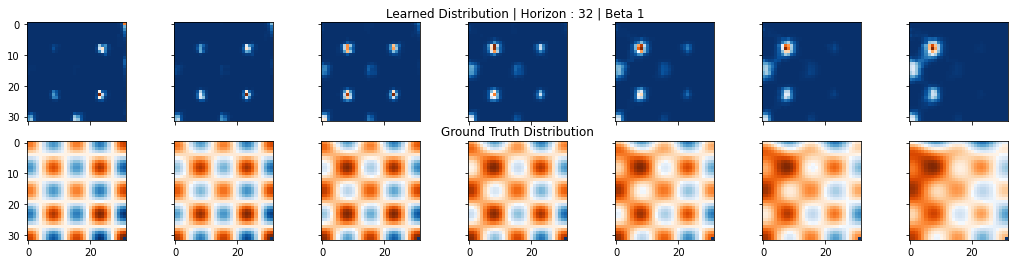

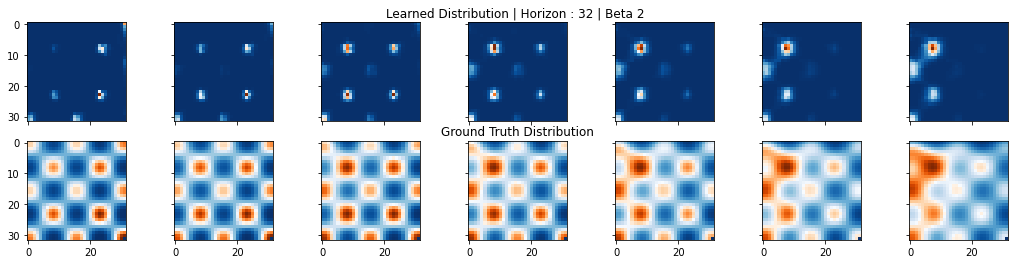

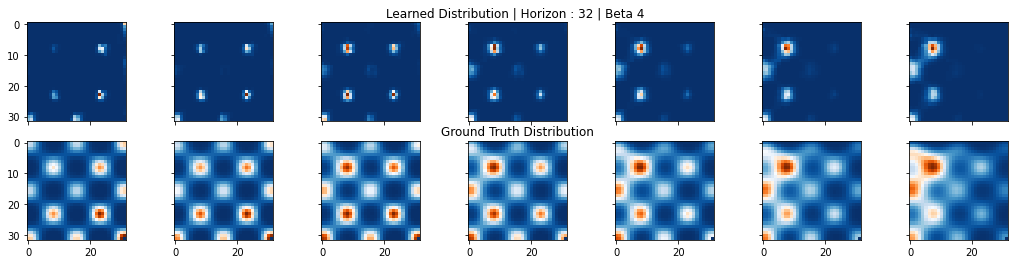

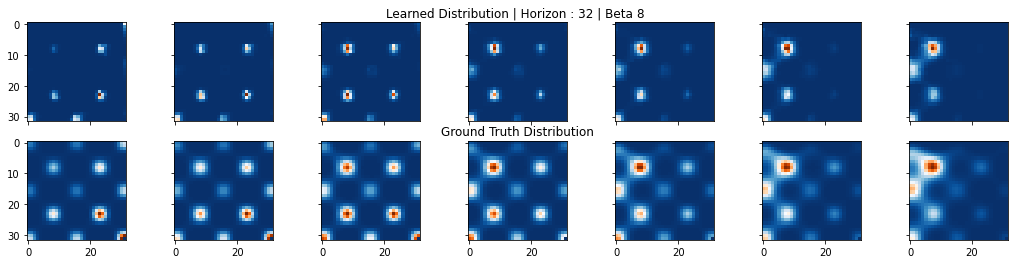

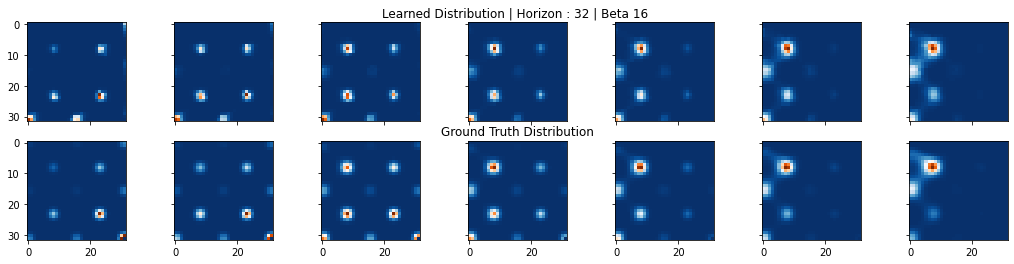

In [ ]:
plot_const_beta_evolution(32)

### Now we plot various losses | Annealing v/s Const Gamma Distribution v/s Dirac Distribution

   Horizons             Method    Losses
0        16         Dirac Beta       1.0
1        16          Annealing  0.383391
2        16  Reverse Annealing  0.580367
3        16   Const Gamma Dist  0.455997
4        32         Dirac Beta       1.0
5        32          Annealing  0.377047
6        32  Reverse Annealing  0.673881
7        32   Const Gamma Dist  0.456792
8        64         Dirac Beta       1.0
9        64          Annealing  0.366688
10       64  Reverse Annealing   0.65709
11       64   Const Gamma Dist  0.493016


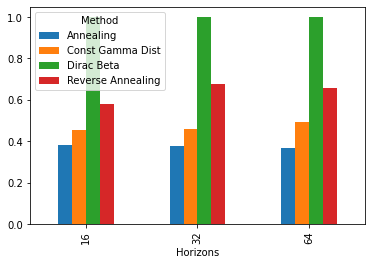

In [48]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
df = pd.DataFrame(columns=['Horizons', 'Method','Losses'])
horizons = [16, 32, 64]


for horizon in horizons:
    # "Const Gamma Dist"
    files = [f"dirac_horizon_{horizon}_beta_8.pkl.gz", f"annealing_v2_horizon_{horizon}.pkl.gz", f"reverse_annealing_horizon_{horizon}.pkl.gz", f"const_dist_horizon_{horizon}.pkl.gz"]
    x_labels = ["Dirac Beta", "Annealing", "Reverse Annealing", "Const Gamma Dist"]
    for idx, f in enumerate(files):
        results = pickle.load(gzip.open(os.getcwd() + '/resultsv2/' + f, 'rb'))
        env = gfn.GridEnv(horizon, funcs=[gfn.branin, gfn.currin, shubert])
        s, r, pos = env.state_info()
        data = results
        errs = []
        logerrs = []
        for (coef, t), dist in zip(data['cond_confs'], data['final_distribution'].T):
            unnorm_p = 0
            for i in range(r.shape[-1]):
                unnorm_p += r[:, i]*coef[i]
            unnorm_p = unnorm_p ** t
            Z = unnorm_p.sum()
            p = unnorm_p / Z
            errs.append(abs(dist - p).mean())
        loss = sum(errs) / len(errs)
        if idx == 0:
            dirac_loss = sum(errs) / len(errs)
            # logp = np.log(unnorm_p) - np.log(Z)
            # logerrs.append(abs(np.log(dist) - logp).mean())
        df = df.append({ 'Horizons' : horizon, 'Method' : x_labels[idx], 'Losses' : loss / dirac_loss}, 
                ignore_index = True)
print(df)
    
df.pivot('Horizons', 'Method', 'Losses').plot(kind='bar')
pp.savefig("loss_plots_all.png")

In [2]:
n = 10
import numpy as np
cond_confs = [
    ([i/n,j/n, k/ n, l/n,  1-(i+j+k + l)/n], temp)
    for i in np.arange(n)
    for j in np.arange(n)
    for k in range(n)
    for l in range(n)
    for temp in [1,2,4,8,16]
    if (i + j + k + l) <= n
]

  Dimension            Method    Losses
0        3d        Dirac Beta  0.000655
1        3d         Annealing  0.000247
2        3d  Const Gamma Dist  0.000299
3        4d        Dirac Beta       NaN
4        4d         Annealing       NaN
5        4d  Const Gamma Dist       NaN
6        5d        Dirac Beta  0.000786
7        5d         Annealing  0.000273
8        5d  Const Gamma Dist  0.000357


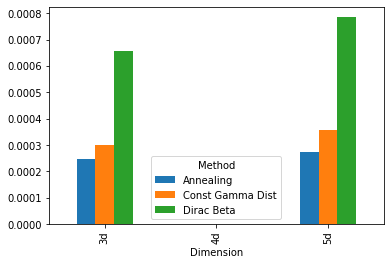

In [8]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
df = pd.DataFrame(columns=['Dimension', 'Method','Losses'])
horizon = 32
dimensions = ["3d", "4d", "5d"]
absolute = True

functions = [[gfn.branin, gfn.currin, shubert], [gfn.branin, gfn.currin, shubert, sphere], [gfn.branin, gfn.currin, shubert, sphere,beale]]
for dim_idx, dim in enumerate(dimensions):
    # "Const Gamma Dist"
    if dim_idx == 0:
        files = [f"dirac_horizon_{horizon}_beta_8.pkl.gz", f"annealing_v2_horizon_{horizon}.pkl.gz", f"const_dist_horizon_{horizon}.pkl.gz"]
    else:
        files = [f"dirac_{dim}_horizon_{horizon}beta_8.pkl.gz", f"annealing_{dim}_horizon_{horizon}beta_8.pkl.gz", f"const_{dim}_horizon_{horizon}beta_8.pkl.gz"]

    x_labels = ["Dirac Beta", "Annealing", "Const Gamma Dist"]
    for idx, f in enumerate(files):
        results = pickle.load(gzip.open(os.getcwd() + '/resultsv2/' + f, 'rb'))
        env = gfn.GridEnv(horizon, funcs=functions[dim_idx])
        s, r, pos = env.state_info()
        data = results
        errs = []
        logerrs = []
        for (coef, t), dist in zip(data['cond_confs'], data['final_distribution'].T):
            unnorm_p = 0
            for i in range(r.shape[-1]):
                unnorm_p += r[:, i]*coef[i]
            unnorm_p = unnorm_p ** t
            Z = unnorm_p.sum()
            p = unnorm_p / Z
            errs.append(abs(dist - p).mean())
        
        loss = sum(errs) / len(errs)
        if not absolute:
            if idx == 0:
                dirac_loss = sum(errs) / len(errs)
        else:
            dirac_loss = 1.0
            # logp = np.log(unnorm_p) - np.log(Z)
            # logerrs.append(abs(np.log(dist) - logp).mean())
        df = df.append({ 'Dimension' : dim, 'Method' : x_labels[idx], 'Losses' : loss / dirac_loss}, 
                ignore_index = True)
print(df)
    
df.pivot('Dimension', 'Method', 'Losses').plot(kind='bar')
pp.savefig("loss_plots_dims_{}_abs.png".format(horizon))

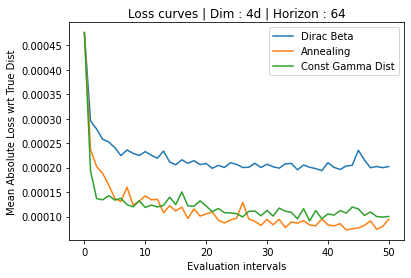

In [10]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
df = pd.DataFrame(columns=['Dimension', 'Method','Losses'])
horizon = 64
dimensions = ["4d"]
absolute = True

functions = [[gfn.branin, gfn.currin, shubert], [gfn.branin, gfn.currin, shubert, sphere], [gfn.branin, gfn.currin, shubert, sphere,beale]]
for dim_idx, dim in enumerate(dimensions):
    # "Const Gamma Dist"
    # if dim_idx == 0:
    #     files = [f"dirac_horizon_{horizon}.pkl.gz", f"annealing_v2_horizon_{horizon}.pkl.gz", f"const_dist_horizon_{horizon}.pkl.gz"]
    # else:
    files = [f"dirac_{dim}_horizon_{horizon}.pkl.gz", f"annealing_{dim}_horizon_{horizon}.pkl.gz", f"const_{dim}_horizon_{horizon}.pkl.gz"]

    x_labels = ["Dirac Beta", "Annealing", "Const Gamma Dist"]
    for idx, f in enumerate(files):
        results = pickle.load(gzip.open(os.getcwd() + '/resultsv3/' + f, 'rb'))
        env = gfn.GridEnv(horizon, funcs=functions[dim_idx])
        s, r, pos = env.state_info()
        data = results["true_losses"]
        pp.plot(data, label=x_labels[idx])
pp.legend()
pp.title("Loss curves | Dim : {} | Horizon : {}".format(dim, horizon))
pp.xlabel("Evaluation intervals")
pp.ylabel("Mean Absolute Loss wrt True Dist")
pp.savefig("loss_curves_{}_{}.png".format(dim, horizon))
        
